In [7]:
import json

AGENTS_FILEPATH = "../round 1/sfcc_2023_agents.json"
CLAIM_HANDLERS_FILEPATH = "../round 1/sfcc_2023_claim_handlers.json"
CLAIMS_FILEPATH = "../round 1/sfcc_2023_claims.json"
DISASTERS_FILEPATH = "../round 1/sfcc_2023_disasters.json"

def load_json_from_file(filename):
    data = None

    with open(filename, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data

agent_data = load_json_from_file(AGENTS_FILEPATH)
claim_handler_data = load_json_from_file(CLAIM_HANDLERS_FILEPATH)
claim_data = load_json_from_file(CLAIMS_FILEPATH)
disaster_data = load_json_from_file(DISASTERS_FILEPATH)

In [23]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import geodatasets

### What is the distribution of disasters across America?


In [8]:
df = pd.DataFrame.from_records(disaster_data)
df.head()

,id,type,state,name,description,start_date,end_date,declared_date,lat,long,radius_miles
0,1,Flood,Alaska,Alaska Flood,Fusce consequat. Nulla nisl. Nunc nisl.\n\nDui...,2023-06-13,2023-06-20,2023-06-17,58.3271,-134.4742,168
1,2,Wildfire,Texas,Texas Wildfire,Duis consequat dui nec nisi volutpat eleifend....,2023-04-11,2023-04-19,2023-04-12,33.5693,-101.8904,235
2,3,Tornado,Virginia,Virginia Tornado,Nullam sit amet turpis elementum ligula vehicu...,2023-04-29,2023-05-07,2023-05-06,38.9776,-77.3860,273
3,4,Earthquake,Connecticut,Connecticut Earthquake,Fusce consequat. Nulla nisl. Nunc nisl.,2023-04-24,2023-05-09,2023-04-28,41.3657,-72.9275,120
4,5,Winter Storm,Missouri,Missouri Winter Storm,Suspendisse potenti. In eleifend quam a odio. ...,2023-03-11,2023-03-21,2023-03-14,39.0663,-94.5674,155


C:\Users\yashs\AppData\Local\Temp/ipykernel_12576/1480417075.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


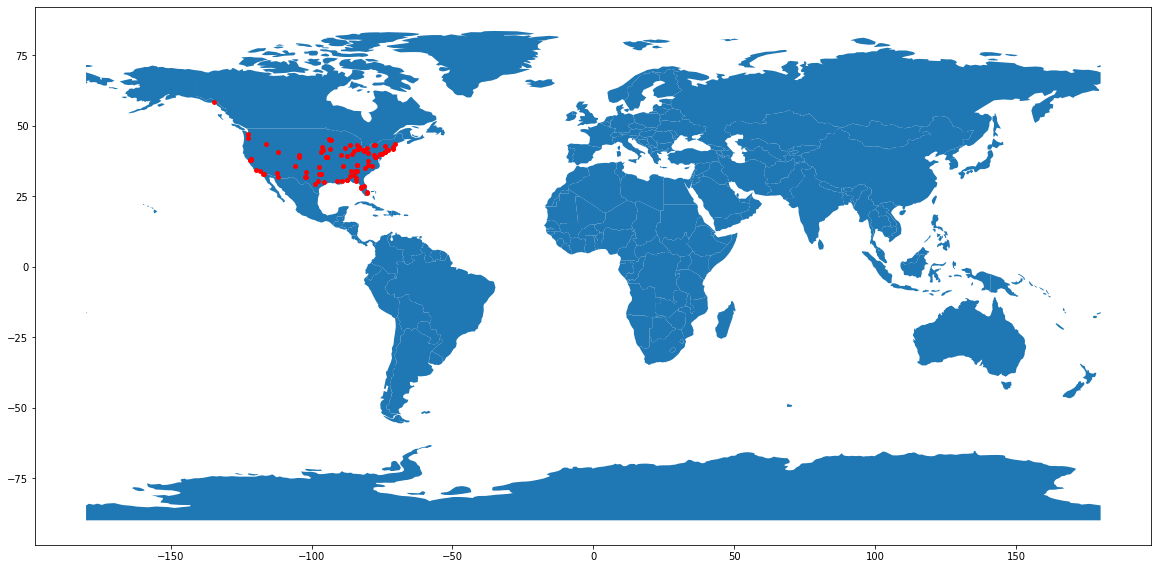

In [47]:
geometry = [Point(coord) for coord in zip(df["long"], df["lat"])]
gdf = GeoDataFrame(df, geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(20, 12)), marker='o', color='red', markersize=15);

As we can see, disasters are concentrated on the East Coast of the United States.

### What types of disasters cause the most damage?

In [48]:
def get_disaster(id):
    for disaster in disaster_data:
        if disaster["id"] == id:
            return disaster

In [53]:
disaster_costs = {}
for claim in claim_data:
    disaster_id = claim["disaster_id"]
    disaster_type = get_disaster(disaster_id)["type"]
    disaster_costs[disaster_type] = disaster_costs.get(disaster_type, 0) + claim["estimate_cost"]

In [71]:
disaster_costs = {k: v for k, v in sorted(disaster_costs.items(), key=lambda item: -item[1])}

<BarContainer object of 8 artists>

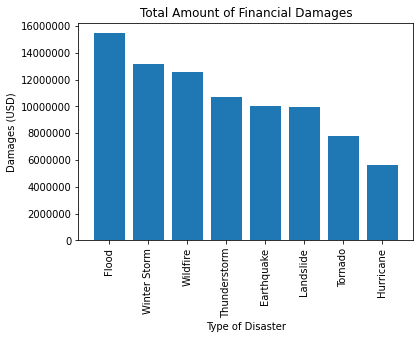

In [76]:
plt.rcParams["axes.formatter.limits"] = (-99, 99)
plt.title("Total Amount of Financial Damages")
plt.xlabel("Type of Disaster")
plt.ylabel("Damages (USD)")
plt.xticks(range(len(disaster_costs)), disaster_costs.keys(), rotation='vertical')
plt.bar(disaster_costs.keys(), disaster_costs.values())

In terms of total cost, floods cause the most financial damage, while hurricanes cause the least.

In [81]:
disaster_counts = {}
for disaster in disaster_data:
    disaster_type = disaster["type"]
    disaster_counts[disaster_type] = disaster_counts.get(disaster_type, 0) + 1

normalized_costs = {k : v / disaster_counts[k] for k, v in disaster_costs.items()}
normalized_costs = {k: v for k, v in sorted(normalized_costs.items(), key=lambda item: -item[1])}

<BarContainer object of 8 artists>

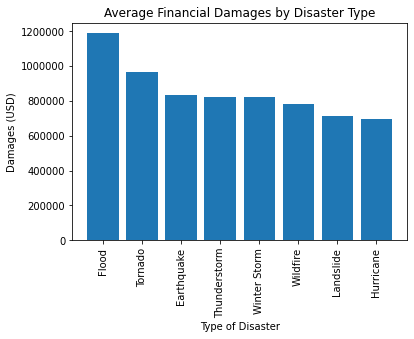

In [82]:
plt.rcParams["axes.formatter.limits"] = (-99, 99)
plt.title("Average Financial Damages by Disaster Type")
plt.xlabel("Type of Disaster")
plt.ylabel("Damages (USD)")
plt.xticks(range(len(normalized_costs)), normalized_costs.keys(), rotation='vertical')
plt.bar(normalized_costs.keys(), normalized_costs.values())

If we instead take the average financial cost instead of the total, an interesting phenomena emerges: some types of disasters like Floods or Hurricanes stay at their positions at the top and bottom respectively. For example, while the average Wildfire can be contained, we can see ones of incredible magnitudes like Hawaii or California. On the other hand, tornadoes occur quite frequently and cause a decent amount of financial damage.